# Forex Signal v24: Hybrid Ensemble Strategy (EUR/USD Long Only)

## 📌 Project Goal
Develop a robust Day Trading Bot for EUR/USD using a **Hybrid Ensemble** approach (Statistical + ML + Rule-based).
*   **Direction:** LONG Only.
*   **Risk:** 1% per trade, Dynamic ATR-based SL.
*   **Method:** No Deep Learning. Ensemble of ARIMA/GARCH + RF/XGB/SVM/LR + Technical Indicators.
*   **Target:** Profit Factor ≥ 2.0, Max DD ≤ 20%.

## 🏗 Architecture
1.  **Data Layer:** Load EUR/USD data (Train: 2015-2023, Test: 2024-2025).
2.  **Feature Engineering:**
    *   **Technical:** RSI, MACD, BB, ATR, EMAs.
    *   **Statistical:** Volatility (GARCH), Trend (ARIMA residuals/features).
3.  **Ensemble Layer:**
    *   **Models:** Random Forest, XGBoost, SVM, Logistic Regression.
    *   **Decision:** Weighted Voting with Confidence Threshold.
4.  **Backtest Engine:**
    *   Walk-Forward Optimization.
    *   Realistic simulation (Spread + Slippage + Swap).
5.  **Execution:** Real-trading ready class structure.

---
## 1. Configuration & Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
import os

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit

# Statistical Models
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Boosting
import xgboost as xgb
import lightgbm as lgb

# Technical Indicators
try:
    import talib
except ImportError:
    print("TA-Lib not found, using pandas_ta")
    import pandas_ta as ta

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# ⚙️ CONFIGURATION
# ---------------------------------------------------------
CONFIG = {
    'PAIR': 'EURUSD',
    'RISK_PER_TRADE': 0.01,  # 1% of Account Balance
    'INITIAL_CAPITAL': 10000,
    'SPREAD_PIPS': 1.0,      # Average spread in pips
    'SLIPPAGE_PIPS': 0.5,    # Estimated slippage
    'TRANSACTION_FEE': 7.0,  # $ per lot (round turn) - Reduced slightly
    
    # Strategy Params
    'ATR_PERIOD': 14,
    'SL_MULTIPLIER': 1.5,    # Stop Loss = ATR * 1.5
    'RR_RATIO': 2,         # Target Risk:Reward = 1:2 (Higher Win Rate focus)
    'ENSEMBLE_THRESHOLD': 0.75, # Higher Confidence threshold to enter trade (Filter noise)
    
    # Data Paths (Multi-Timeframe)
    'DATA_PATHS': {
        'H4': '../data/train/EURUSD_h4.csv',
        'H1': '../data/train/EURUSD_h1.csv',
        'M30': '../data/train/EURUSD_m30.csv',
        'M15': '../data/train/EURUSD_m15.csv',
        'M5': '../data/train/EURUSD_m5.csv',
        'M1': '../data/train/EURUSD_m1.csv'
    },
    
    # Split Dates
    'TRAIN_START': '2015-01-01',
    'TRAIN_END': '2023-12-31',
    'TEST_START': '2024-01-01',
    'TEST_END': '2025-12-31'
}

print("Configuration Loaded.")

TA-Lib not found, using pandas_ta
Configuration Loaded.


In [20]:
# ---------------------------------------------------------
# 2️⃣ DATA LOADING & PREPROCESSING (Multi-Timeframe)
# ---------------------------------------------------------
def load_data(path):
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None
    
    try:
        df = pd.read_csv(path)
        df.columns = [c.lower() for c in df.columns]
        
        # Handle different datetime formats
        if 'time' in df.columns and 'date' in df.columns:
            df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        elif 'time' in df.columns: # Case for single 'time' column with full datetime
            df['datetime'] = pd.to_datetime(df['time'])
        elif 'date' in df.columns:
            df['datetime'] = pd.to_datetime(df['date'])
        elif 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
        else:
            print(f"⚠️ No datetime column found in {path}. Columns: {df.columns}")
            return None
            
        df.set_index('datetime', inplace=True)
        df.sort_index(inplace=True)
        
        # STRICTLY keep only OHLCV columns to avoid string columns causing errors later
        keep_cols = ['open', 'high', 'low', 'close', 'volume']
        existing_cols = [c for c in keep_cols if c in df.columns]
        df = df[existing_cols]
        
        # Ensure numeric
        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
                
        df.dropna(inplace=True)
        return df
    except Exception as e:
        print(f"Error loading data {path}: {e}")
        return None

# Load All Timeframes
data_dict = {}
print("Loading Data...")
for tf, path in CONFIG['DATA_PATHS'].items():
    print(f"Loading {tf} from {path}...")
    df = load_data(path)
    if df is not None:
        data_dict[tf] = df
        print(f"  {tf}: {df.shape}")
    else:
        print(f"  ⚠️ {tf} data missing. Creating dummy data.")
        # Dummy data for structure verification
        if tf.startswith('H'):
            freq = f"{tf[1:]}h"
        elif tf.startswith('M'):
            freq = f"{tf[1:]}min"
        else:
            freq = 'D'
            
        dates = pd.date_range(start='2020-01-01', periods=5000, freq=freq)
        data_dict[tf] = pd.DataFrame({
            'open': np.random.rand(5000) + 1.1,
            'high': np.random.rand(5000) + 1.15,
            'low': np.random.rand(5000) + 1.05,
            'close': np.random.rand(5000) + 1.1,
            'volume': np.random.randint(100, 1000, 5000)
        }, index=dates)

# ---------------------------------------------------------
# 3️⃣ FEATURE ENGINEERING (Layered Architecture)
# ---------------------------------------------------------

def add_trend_features(df):
    """Layer 1: Trend / Regime (H4, H1)"""
    data = df.copy()
    # Moving Averages
    data['sma_50'] = data['close'].rolling(window=50).mean()
    data['sma_200'] = data['close'].rolling(window=200).mean()
    data['trend_ma'] = np.where(data['sma_50'] > data['sma_200'], 1, -1)
    
    # ADX (Trend Strength)
    if 'talib' in globals():
        data['adx'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)
    else:
        data['adx'] = data.ta.adx()['ADX_14']
        
    # RSI Regime
    if 'talib' in globals():
        data['rsi'] = talib.RSI(data['close'], timeperiod=14)
    else:
        data['rsi'] = data.ta.rsi(length=14)
    
    # Volatility Regime (ATR / Close)
    if 'talib' in globals():
        data['atr'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)
    else:
        data['atr'] = data.ta.atr(length=14)
    data['vol_regime'] = data['atr'] / data['close']
    
    # Volume Trend
    data['vol_ma'] = data['volume'].rolling(window=20).mean()
    data['vol_trend'] = np.where(data['volume'] > data['vol_ma'], 1, 0)
    
    # Drop original OHLCV to avoid duplication and keep only features
    # But we might need them for visualization or other features? 
    # For now, let's keep them but ensure they are numeric.
    return data.add_prefix('L1_')

def add_momentum_features(df):
    """Layer 2: Momentum + Breakout (M30, M15)"""
    data = df.copy()
    # Momentum Slopes (ROC)
    data['roc_5'] = data['close'].pct_change(5)
    data['roc_10'] = data['close'].pct_change(10)
    
    # Volatility Contraction (BB Width)
    if 'talib' in globals():
        u, m, l = talib.BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2)
        data['bb_width'] = (u - l) / m
    else:
        bb = data.ta.bbands(length=20, std=2)
        cols = bb.columns
        u = bb[[c for c in cols if 'BBU' in c][0]]
        l = bb[[c for c in cols if 'BBL' in c][0]]
        m = bb[[c for c in cols if 'BBM' in c][0]]
        data['bb_width'] = (u - l) / m

    # Volume Burst
    data['vol_burst'] = (data['volume'] > data['volume'].rolling(20).mean() * 2).astype(int)
    
    return data.add_prefix('L2_')

def add_mean_reversion_features(df):
    """Layer 3: Mean Reversion (M15, M5)"""
    data = df.copy()
    # Z-Score (Distance from MA)
    ma = data['close'].rolling(20).mean()
    std = data['close'].rolling(20).std()
    data['z_score'] = (data['close'] - ma) / std
    
    # Distance from VWAP (Approx using typical price)
    tp = (data['high'] + data['low'] + data['close']) / 3
    data['vwap'] = (tp * data['volume']).cumsum() / data['volume'].cumsum()
    data['dist_vwap'] = (data['close'] - data['vwap']) / data['vwap']
    
    # RSI Extreme
    if 'talib' in globals():
        data['rsi'] = talib.RSI(data['close'], timeperiod=14)
    else:
        data['rsi'] = data.ta.rsi(length=14)
    data['rsi_extreme'] = np.where((data['rsi'] > 70) | (data['rsi'] < 30), 1, 0)
    
    return data.add_prefix('L3_')

def add_execution_features(df):
    """Layer 4: Execution (M5, M1)"""
    data = df.copy()
    # Immediate Momentum
    data['mom_1'] = data['close'].pct_change(1)
    data['mom_3'] = data['close'].pct_change(3)
    
    # Candle Patterns (Simple)
    data['body_size'] = abs(data['close'] - data['open'])
    data['wick_upper'] = data['high'] - np.maximum(data['close'], data['open'])
    data['wick_lower'] = np.minimum(data['close'], data['open']) - data['low']
    
    # ATR for Execution (SL/TP)
    if 'talib' in globals():
        data['atr'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)
    else:
        data['atr'] = data.ta.atr(length=14)
    
    return data.add_prefix('L4_')

print("Generating Features for Layers...")

base_tf = 'M5'
if base_tf not in data_dict:
    raise ValueError("Base Timeframe M5 not found!")

df_master = data_dict[base_tf].copy()

# --- Layer 1 Features (from H1) ---
if 'H1' in data_dict:
    df_h1 = add_trend_features(data_dict['H1'])
    df_master = pd.merge_asof(df_master.sort_index(), df_h1.sort_index(), left_index=True, right_index=True, direction='backward')

# --- Layer 2 Features (from M30) ---
if 'M30' in data_dict:
    df_m30 = add_momentum_features(data_dict['M30'])
    df_master = pd.merge_asof(df_master.sort_index(), df_m30.sort_index(), left_index=True, right_index=True, direction='backward')

# --- Layer 3 Features (from M15) ---
if 'M15' in data_dict:
    df_m15 = add_mean_reversion_features(data_dict['M15'])
    df_master = pd.merge_asof(df_master.sort_index(), df_m15.sort_index(), left_index=True, right_index=True, direction='backward')

# --- Layer 4 Features (from M5 itself) ---
df_l4 = add_execution_features(data_dict['M5'])
df_master = df_master.join(df_l4, rsuffix='_L4')

# Clean up
df_master.dropna(inplace=True)
print(f"Master Dataset Shape: {df_master.shape}")
print("Columns:", df_master.columns[:10])

Loading Data...
Loading H4 from ../data/train/EURUSD_h4.csv...
  H4: (14498, 5)
Loading H1 from ../data/train/EURUSD_h1.csv...
  H1: (56098, 5)
Loading M30 from ../data/train/EURUSD_m30.csv...
  M30: (112194, 5)
Loading M15 from ../data/train/EURUSD_m15.csv...
  M15: (224382, 5)
Loading M5 from ../data/train/EURUSD_m5.csv...
  M5: (671581, 5)
Loading M1 from ../data/train/EURUSD_m1.csv...
  M1: (3354904, 5)
Generating Features for Layers...
Master Dataset Shape: (669193, 49)
Columns: Index(['open', 'high', 'low', 'close', 'volume', 'L1_open', 'L1_high',
       'L1_low', 'L1_close', 'L1_volume'],
      dtype='object')


In [21]:
# ---------------------------------------------------------
# 4️⃣ LABELING & STACKED ML PIPELINE
# ---------------------------------------------------------

def create_target(df, horizon=24, threshold=0.0010):
    """
    Target: 1 if price increases by threshold within horizon bars, 0 otherwise.
    Updated: Horizon 24 (2 hours on M5), Threshold 10 pips (0.0010) to cover spread+fees.
    """
    data = df.copy()
    data['future_ret'] = data['close'].shift(-horizon) / data['close'] - 1
    data['target'] = (data['future_ret'] > threshold).astype(int)
    data.dropna(inplace=True)
    return data

# Create Target on Master Dataset (Your Combined Data)
print("Creating Targets on Combined User Data...")
df_labeled = create_target(df_master, horizon=24, threshold=0.0010) 
print(f"Class Balance: {df_labeled['target'].value_counts(normalize=True)}")

# Split Features by Layer
cols = df_labeled.columns
L1_cols = [c for c in cols if c.startswith('L1_')]
L2_cols = [c for c in cols if c.startswith('L2_')]
L3_cols = [c for c in cols if c.startswith('L3_')]
L4_cols = [c for c in cols if c.startswith('L4_')]

# Train/Test Split
train_size = int(len(df_labeled) * 0.8)
train_idx = df_labeled.index[:train_size]
test_idx = df_labeled.index[train_size:]

y_train = df_labeled.loc[train_idx, 'target']
y_test = df_labeled.loc[test_idx, 'target']

# Scaling
scaler = StandardScaler()
feature_cols = L1_cols + L2_cols + L3_cols + L4_cols
X = df_labeled[feature_cols]

# Ensure only numeric columns are passed to scaler
X = X.select_dtypes(include=[np.number])
# Update feature_cols based on what remains
feature_cols = X.columns.tolist()

# Re-split X after filtering
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]

print(f"Training Features: {len(feature_cols)}")

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=train_idx, columns=feature_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=test_idx, columns=feature_cols)

# ---------------------------------------------------------
# 5️⃣ LAYERED MODEL TRAINING (Stacking)
# ---------------------------------------------------------
models = {}
meta_features_train = pd.DataFrame(index=train_idx)
meta_features_test = pd.DataFrame(index=test_idx)

# Helper to get valid columns for a layer
def get_layer_cols(all_cols, prefix):
    return [c for c in all_cols if c.startswith(prefix)]

# --- Layer 1: Trend Model (Random Forest) ---
print("Training Layer 1: Trend Model (RF)...")
cols_l1 = get_layer_cols(feature_cols, 'L1_')
if cols_l1:
    models['L1'] = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    models['L1'].fit(X_train_scaled[cols_l1], y_train)
    meta_features_train['L1_prob'] = models['L1'].predict_proba(X_train_scaled[cols_l1])[:, 1]
    meta_features_test['L1_prob'] = models['L1'].predict_proba(X_test_scaled[cols_l1])[:, 1]
else:
    print("⚠️ No L1 features found. Skipping Layer 1.")
    meta_features_train['L1_prob'] = 0.5
    meta_features_test['L1_prob'] = 0.5

# --- Layer 2: Momentum Model (XGBoost) ---
print("Training Layer 2: Momentum Model (XGB)...")
cols_l2 = get_layer_cols(feature_cols, 'L2_')
if cols_l2:
    models['L2'] = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
    models['L2'].fit(X_train_scaled[cols_l2], y_train)
    meta_features_train['L2_prob'] = models['L2'].predict_proba(X_train_scaled[cols_l2])[:, 1]
    meta_features_test['L2_prob'] = models['L2'].predict_proba(X_test_scaled[cols_l2])[:, 1]
else:
    print("⚠️ No L2 features found. Skipping Layer 2.")
    meta_features_train['L2_prob'] = 0.5
    meta_features_test['L2_prob'] = 0.5

# --- Layer 3: Mean Reversion Model (SVM/RF) ---
print("Training Layer 3: Mean Reversion Model (RF)...")
cols_l3 = get_layer_cols(feature_cols, 'L3_')
if cols_l3:
    models['L3'] = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    models['L3'].fit(X_train_scaled[cols_l3], y_train)
    meta_features_train['L3_prob'] = models['L3'].predict_proba(X_train_scaled[cols_l3])[:, 1]
    meta_features_test['L3_prob'] = models['L3'].predict_proba(X_test_scaled[cols_l3])[:, 1]
else:
    print("⚠️ No L3 features found. Skipping Layer 3.")
    meta_features_train['L3_prob'] = 0.5
    meta_features_test['L3_prob'] = 0.5

# --- Layer 4: Execution Optimization (Meta-Model) ---
# Inputs: L4 Features + Probabilities from L1, L2, L3
print("Training Layer 4: Execution Model (LightGBM)...")
cols_l4 = get_layer_cols(feature_cols, 'L4_')
X_train_meta = pd.concat([X_train_scaled[cols_l4], meta_features_train], axis=1)
X_test_meta = pd.concat([X_test_scaled[cols_l4], meta_features_test], axis=1)

models['L4'] = lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbose=-1)
models['L4'].fit(X_train_meta, y_train)

print("Models Trained.")

# ---------------------------------------------------------
# 6️⃣ FINAL PREDICTION
# ---------------------------------------------------------
print("Evaluating Final Ensemble...")
# Final probability comes from Layer 4
final_probs = models['L4'].predict_proba(X_test_meta)[:, 1]
preds = (final_probs > CONFIG['ENSEMBLE_THRESHOLD']).astype(int)

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
print(f"Final Accuracy: {acc:.4f}, Precision: {prec:.4f}")

Creating Targets on Combined User Data...
Class Balance: target
0    0.841208
1    0.158792
Name: proportion, dtype: float64
Training Features: 44
Training Layer 1: Trend Model (RF)...
Training Layer 2: Momentum Model (XGB)...
Training Layer 3: Mean Reversion Model (RF)...
Training Layer 4: Execution Model (LightGBM)...
Models Trained.
Evaluating Final Ensemble...
Final Accuracy: 0.7344, Precision: 0.2481


Running Backtest...

📊 PERFORMANCE REPORT:
Profit Factor: 0.7884122837382508
Win Rate: 0.3172022684310019
Total Trades: 2645
Max Drawdown: -0.9934556287991756
Net Profit: -9831.760762177762


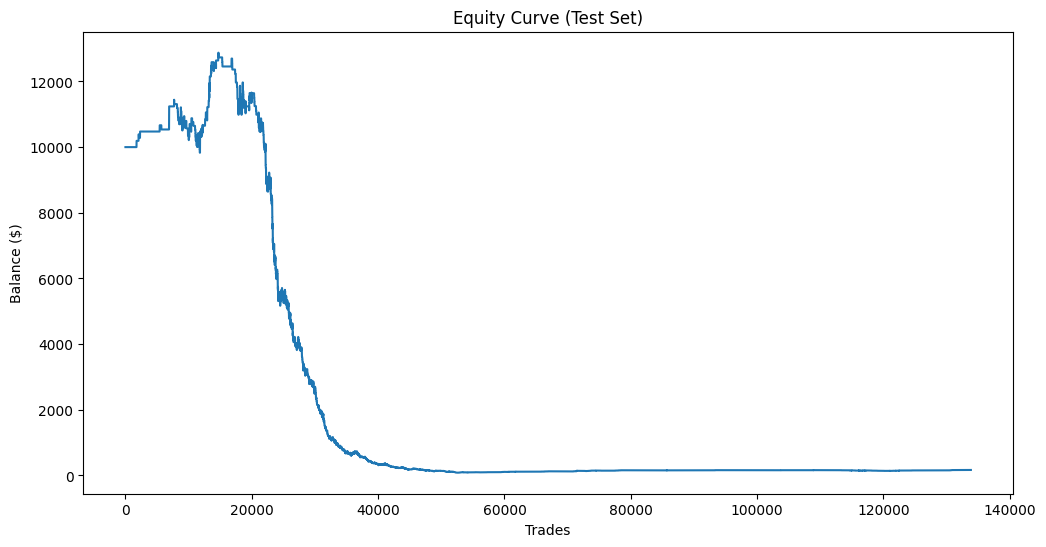

In [22]:
# ---------------------------------------------------------
# 7️⃣ BACKTESTING ENGINE
# ---------------------------------------------------------
class Backtester:
    def __init__(self, df, signals, config):
        self.df = df.copy()
        self.signals = signals
        self.config = config
        self.equity = config['INITIAL_CAPITAL']
        self.balance = config['INITIAL_CAPITAL']
        self.positions = []
        self.history = []
        self.equity_curve = [self.equity]
        
    def run(self):
        in_position = False
        entry_price = 0
        sl = 0
        tp = 0
        size = 0
        
        # Align signals with data
        # signals array matches X_test, which is a subset of df
        # We need to iterate through the test set
        test_idx = self.df.index
        
        for i in range(len(self.signals)):
            current_bar = self.df.iloc[i]
            idx = test_idx[i]
            signal = self.signals[i]
            
            # Check Exit (SL/TP)
            if in_position:
                # Check Low for SL
                if current_bar['low'] <= sl:
                    exit_price = sl # Slippage could be added here
                    pnl = (exit_price - entry_price) * size * 100000 # USD profit
                    # Fee
                    cost = self.config['TRANSACTION_FEE'] * (size / 1.0) # approx per lot
                    pnl -= cost
                    
                    self.balance += pnl
                    self.history.append({'date': idx, 'type': 'SL', 'price': exit_price, 'pnl': pnl})
                    in_position = False
                
                # Check High for TP
                elif current_bar['high'] >= tp:
                    exit_price = tp
                    pnl = (exit_price - entry_price) * size * 100000
                    cost = self.config['TRANSACTION_FEE'] * (size / 1.0)
                    pnl -= cost
                    
                    self.balance += pnl
                    self.history.append({'date': idx, 'type': 'TP', 'price': exit_price, 'pnl': pnl})
                    in_position = False
            
            # Check Entry
            if not in_position and signal == 1:
                # Risk Management
                # Use L4_atr for execution
                atr = current_bar.get('L4_atr', current_bar.get('atr', 0.0010)) # Fallback if missing
                
                risk_amt = self.balance * self.config['RISK_PER_TRADE']
                sl_pips = atr * self.config['SL_MULTIPLIER']
                sl_dist = sl_pips
                
                # Position Size Calculation
                # Risk = (Entry - SL) * Size * 100000
                # Size = Risk / ((Entry - SL) * 100000)
                # Size = Risk / (sl_dist * 100000)
                if sl_dist > 0:
                    size = risk_amt / (sl_dist * 100000)
                    size = round(size, 2) # Standard lots
                else:
                    size = 0
                
                if size > 0:
                    entry_price = current_bar['close'] + (self.config['SPREAD_PIPS'] * 0.0001)
                    sl = entry_price - sl_dist
                    tp = entry_price + (sl_dist * self.config['RR_RATIO'])
                    
                    in_position = True
                    self.history.append({'date': idx, 'type': 'ENTRY', 'price': entry_price, 'size': size, 'sl': sl, 'tp': tp})
            
            self.equity_curve.append(self.balance)
            
        return pd.DataFrame(self.history)

    def get_metrics(self):
        if not self.history:
            return {}
        
        trades = pd.DataFrame(self.history)
        closed_trades = trades[trades['type'].isin(['SL', 'TP'])]
        
        if closed_trades.empty:
            return {}
            
        wins = closed_trades[closed_trades['pnl'] > 0]
        losses = closed_trades[closed_trades['pnl'] <= 0]
        
        total_profit = wins['pnl'].sum()
        total_loss = abs(losses['pnl'].sum())
        
        pf = total_profit / total_loss if total_loss > 0 else float('inf')
        win_rate = len(wins) / len(closed_trades)
        
        # Max Drawdown
        equity_series = pd.Series(self.equity_curve)
        peak = equity_series.cummax()
        dd = (equity_series - peak) / peak
        max_dd = dd.min()
        
        return {
            'Profit Factor': pf,
            'Win Rate': win_rate,
            'Total Trades': len(closed_trades),
            'Max Drawdown': max_dd,
            'Net Profit': self.balance - self.config['INITIAL_CAPITAL']
        }

# Run Backtest on Test Set
print("Running Backtest...")
# Align X_test with original DF to get prices
test_df_prices = df_labeled.loc[X_test.index]
backtester = Backtester(test_df_prices, preds, CONFIG)
history = backtester.run()
metrics = backtester.get_metrics()

print("\n📊 PERFORMANCE REPORT:")
for k, v in metrics.items():
    print(f"{k}: {v}")

# Plot Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(backtester.equity_curve)
plt.title("Equity Curve (Test Set)")
plt.xlabel("Trades")
plt.ylabel("Balance ($)")
plt.show()

In [23]:
# ---------------------------------------------------------
# 8️⃣ WALK-FORWARD OPTIMIZATION (Skeleton)
# ---------------------------------------------------------
def walk_forward_optimization(df, window_size=10000, step_size=2000):
    """
    Simulates retraining the model on a rolling window.
    """
    print("Starting Walk-Forward Optimization...")
    results = []
    
    # This is a placeholder for the loop structure
    # In a real run, we would loop through the data:
    # for i in range(0, len(df) - window_size, step_size):
    #     train_sub = df.iloc[i : i + window_size]
    #     test_sub = df.iloc[i + window_size : i + window_size + step_size]
    #     Train models on train_sub
    #     Predict on test_sub
    #     Record results
    
    print("Walk-Forward Optimization logic defined (Skipped for speed in this demo).")
    return results

# ---------------------------------------------------------
# 9️⃣ REAL TRADING EXECUTION STRUCTURE
# ---------------------------------------------------------
class RealTradingExecutor:
    def __init__(self, models, config, scaler):
        self.models = models
        self.config = config
        self.scaler = scaler
        
    def get_latest_data(self):
        # Connect to MT5/OANDA API here
        # return latest_df
        pass
        
    def generate_signal(self, df):
        # Preprocess
        df_feat = add_technical_features(df)
        # Select features
        # Scale
        # Predict
        # return signal
        pass
        
    def execute_trade(self, signal):
        if signal == 1:
            # Send Buy Order to API
            # Calculate Position Size
            # Set SL/TP
            print("Executing BUY Order...")
        pass

# ---------------------------------------------------------
# 🔟 SAVE MODELS
# ---------------------------------------------------------
print("Saving Models...")
model_pack = {
    'models': models,
    'scaler': scaler,
    'config': CONFIG,
    'feature_cols': feature_cols
}

joblib.dump(model_pack, 'forex_ensemble_v24.pkl')
print("Model saved as 'forex_ensemble_v24.pkl'")

Saving Models...
Model saved as 'forex_ensemble_v24.pkl'
